# Custom Models and Training with TensorFlow

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
from packaging.version import Version
assert Version(tf.__version__) >= Version("2.4")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
# Jupyter - if you want to always print the last expression or assignment\n
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

## Using TensorFlow like NumPy

### Tensors and Operations

In [5]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])  # 2x3 matrix

I0000 00:00:1762222993.936453   10074 gpu_device.cc:2395] Ignoring visible gpu device (device: 0, name: AMD Radeon Graphics, pci bus id: 0000:c1:00.0) with AMDGPU version : gfx1152. The supported AMDGPU versions are gfx900, gfx906, gfx908, gfx90a, gfx942, gfx950, gfx1030, gfx1100, gfx1101, gfx1103, gfx1150, gfx1151, gfx1200, gfx1201.


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [6]:
tf.constant(42)  # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [7]:
t.shape

TensorShape([2, 3])

In [8]:
t.dtype

tf.float32

In [9]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [10]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [11]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [12]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [13]:
# Matrix multiplication, equivalent to tf.matmul()
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### Tensors and Numpy

In [14]:
a = np.array([2., 4., 5.])

array([2., 4., 5.])

In [15]:
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [16]:
t.numpy()  # or np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [17]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [18]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Type conversions

In [19]:
# tf.constant(2.) + tf.constant(40)  # type conversions are not done automatically to avoid degrading performances

In [20]:
#tf.constant(2.) + tf.constant(40., dtype=tf.float64)  # even adding float32 and float64 is not allowed

In [21]:
t2 = tf.constant(40., dtype=tf.float64)

<tf.Tensor: shape=(), dtype=float64, numpy=40.0>

In [22]:
tf.constant(2.) + tf.cast(t2, tf.float32)  # so we use casting

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Variables

In [23]:
v = tf.Variable(t)

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [24]:
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [25]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [26]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [27]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

## Customizing Models and Training Algorithms

### Custom Loss Functions

In [28]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

array([[-1.15780104, -0.28673138, -0.49550877, ...,  0.38899735,
         0.19374821,  0.2870474 ],
       [-0.7125531 ,  0.10880952, -0.16332973, ..., -0.11818174,
        -0.23725261,  0.06215231],
       [-0.2156101 ,  1.8491895 , -0.57982788, ..., -0.67694905,
         1.00890193, -1.4271529 ],
       ...,
       [-0.90351581,  0.66256679, -0.8562583 , ...,  0.68837768,
        -0.76194926,  0.66187253],
       [ 1.56873373, -1.78978682,  0.75535703, ..., -0.18226735,
         1.34152212, -0.73747465],
       [ 1.43527981,  0.58345861,  0.10928062, ..., -0.17819366,
        -0.82285155,  0.59190517]])

In [29]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

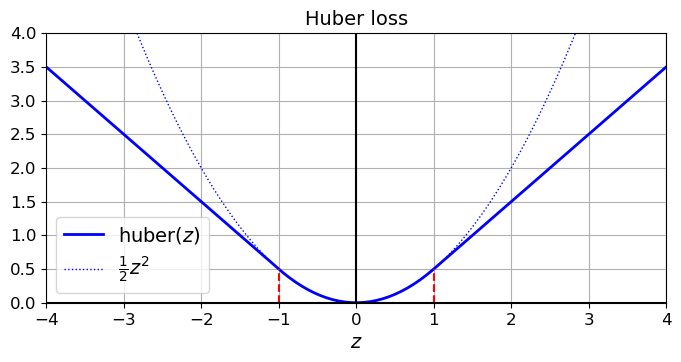

In [30]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [31]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

/home/manitou/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(loss=huber_fn, optimizer="nadam")
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.7453 - val_loss: 1.7711
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 1.2465 - val_loss: 1.7813


### Saving and Loading Models That Contain Custom Components

In [34]:
model.save("my_model_with_a_custom_loss.keras")

In [35]:
model = keras.models.load_model('my_model_with_a_custom_loss.keras', custom_objects={'huber_fn': huber_fn})

<Sequential name=sequential, built=True>

In [36]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold* tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    return huber_fn

In [37]:
model.compile(loss=create_huber(2.0), optimizer='nadam')

In [38]:
model.save('my_model_with_a_custom_loss_threshold.keras')

In [39]:
model = keras.models.load_model('my_model_with_a_custom_loss_threshold.keras',
                                custom_objects={'huber_fn': create_huber(2.0)})

/home/manitou/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 11 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [40]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold* tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

In [41]:
model.compile(loss=HuberLoss(2.), optimizer='nadam')
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8686 - val_loss: 2.6667
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 1.5369 - val_loss: 2.7244


In [42]:
model.save('my_model_with_a_custom_loss_class.keras')

In [43]:
model = keras.models.load_model('my_model_with_a_custom_loss_class.keras',
                                custom_objects={'HuberLoss': HuberLoss})

<Sequential name=sequential, built=True>

In [44]:
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5625 - val_loss: 2.7767
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 1.4984 - val_loss: 2.8261


In [45]:
model.loss.threshold

2.0

### Custom Activation Functions, Initializers, Regularizers, and Constraints

In [46]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [47]:
def my_softplus(z):  # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

In [48]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [49]:
def my_positive_weights(weights):  # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0, tf.zeros_like(weights), weights)

In [50]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, strength=1.0):
        self.strength = strength

    def __call__(self, weights):
            return self.strength * tf.reduce_sum(tf.abs(0.01 + weights))

In [51]:
my_l1_regularizer = MyL1Regularizer(strength=1.0)

In [52]:
class MyPositiveWeights(keras.constraints.Constraint):
    def __init__(self):
        super().__init__()

    def __call__(self, weights):
        return tf.where(weights < 0, tf.zeros_like(weights), weights)

In [53]:
my_positive_weights = MyPositiveWeights()

In [54]:
layer = keras.layers.Dense(30, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

<Dense name=dense, built=False>

### Custom Metrics

In [55]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

<Sequential name=sequential, built=False>

In [57]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [58]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.1377 - mae: 1.2162 - val_loss: 4.7322 - val_mae: 1.0567
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 2.4641 - mae: 0.8325 - val_loss: 2.4400 - val_mae: 0.6660


**Note**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [59]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [60]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - huber_fn: 0.6029 - loss: 0.9392
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - huber_fn: 0.7655 - loss: 0.7011


In [61]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.9392408132553101, np.float64(0.299176049632511))

**Note**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [62]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [63]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - huber_fn: 0.7028 - loss: 0.6599
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - huber_fn: 0.6580 - loss: 0.6371


In [64]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.6598902940750122, np.float64(0.3558745593571137))

### Streaming metrics

In [65]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.800000011920929>

In [66]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [67]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [68]:
precision.variables

[<Variable path=precision/true_positives, shape=(1,), dtype=float32, value=[4.]>,
 <Variable path=precision/false_positives, shape=(1,), dtype=float32, value=[4.]>]

In [69]:
precision.reset_state()

Creating a streaming metric:

In [70]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_variable(shape=(), initializer="zeros", name="total")
        self.count = self.add_variable(shape=(), initializer="zeros", name="count")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [71]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [72]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [73]:
m.variables

[<Variable path=huber_metric/total, shape=(), dtype=float32, value=21.0>,
 <Variable path=huber_metric/count, shape=(), dtype=float32, value=3.0>]

In [74]:
m.reset_state()
m.variables

[<Variable path=huber_metric/total, shape=(), dtype=float32, value=0.0>,
 <Variable path=huber_metric/count, shape=(), dtype=float32, value=0.0>]

Let's check that the `HuberMetric` class works well:

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

<Sequential name=sequential, built=True>

In [77]:
huber_metric = HuberMetric(2.0)

<HuberMetric name=huber_metric>

In [78]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[huber_metric])

In [79]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - huber_metric: 0.8700 - loss: 0.8700
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - huber_metric: 0.2468 - loss: 0.2468


In [80]:
model.save("my_model_with_a_custom_metric.keras")

In [81]:
model = keras.models.load_model("my_model_with_a_custom_metric.keras",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

<Sequential name=sequential, built=True>

In [82]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - huber_metric: 0.2327 - loss: 0.2327
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - huber_metric: 0.2233 - loss: 0.2233


**Warning**: We can no longer use `model.metrics[-1]` to access the `huber_metric` object.

In [83]:
huber_metric.threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [84]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [85]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [86]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

<Sequential name=sequential, built=True>

In [87]:
huber_metric = HuberMetric(2.0)

<HuberMetric name=HuberMetric>

In [88]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[huber_metric])

In [89]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - HuberMetric: 0.8444 - loss: 0.4191
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - HuberMetric: 0.2376 - loss: 0.1179


In [90]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.41905292868614197, np.float64(0.419053011108491))

In [91]:
model.save("my_model_with_a_custom_metric_v2.keras")

In [92]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.keras",
                                custom_objects={"HuberMetric": HuberMetric})

<Sequential name=sequential, built=True>

In [93]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - HuberMetric: 0.2277 - loss: 0.2002
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - HuberMetric: 0.2213 - loss: 0.1958


In [94]:
huber_metric.threshold

2.0

### Custom Layers

In [95]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

<Lambda name=lambda, built=False>

In [96]:
exponential_layer(tf.constant([-1., 0., 1.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [97]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [98]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.6018 - val_loss: 0.3940
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.5049 - val_loss: 0.3869
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.6542 - val_loss: 0.4766
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.4823 - val_loss: 0.4281
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.4409 - val_loss: 0.4003
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.4240


0.42401692271232605

In [99]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(list(batch_input_shape)[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [100]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [101]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

/tmp/ipykernel_10074/2050359931.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Sequential name=sequential, built=True>

In [102]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - loss: 1.9514 - val_loss: 0.7692
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.6462 - val_loss: 0.5306
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.5463


0.5463308691978455

In [103]:
model.save("my_model_with_a_custom_layer.keras")

In [104]:
model = keras.models.load_model("my_model_with_a_custom_layer.keras",
                                custom_objects={"MyDense": MyDense})

<Sequential name=sequential, built=True>

In [105]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

Our custom layer can be called using the functional API like this:

In [106]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

Note that the `call()` method receives symbolic inputs, whose shape is only partially specified (at this stage, we don't know the batch size, which is why the first dimension is `None`):

We can also pass actual data to the custom layer. To test this, let's split each dataset's inputs into two parts, with four features each:

In [107]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# Printing the splitted data shapes
X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

Now notice that the shapes are fully specified:

In [108]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


Let's build a more complete model using the functional API (this is just a toy example, don't expect awesome performance):

In [109]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=(X_train_scaled_A.shape[-1],))
input_B = keras.layers.Input(shape=(X_train_scaled_B.shape[-1],))
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

<Functional name=functional, built=True>

In [110]:
model.compile(loss='mse', optimizer='nadam')

In [111]:
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
309/363 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 3.4507X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8881 - val_loss: 1.0120
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.9844 - val_loss: 0.9648


Now let's create a layer with a different behavior during training and testing:

In [112]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

Here's a simple model that uses this custom layer:

In [113]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

<Sequential name=sequential, built=False>

In [114]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2249 - val_loss: 3.5342
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 1.0474 - val_loss: 1.8015
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.7732


0.7731719017028809

## Custom Models

In [115]:
X_new_scaled = X_test_scaled

array([[-1.15780104, -0.28673138, -0.49550877, ...,  0.38899735,
         0.19374821,  0.2870474 ],
       [-0.7125531 ,  0.10880952, -0.16332973, ..., -0.11818174,
        -0.23725261,  0.06215231],
       [-0.2156101 ,  1.8491895 , -0.57982788, ..., -0.67694905,
         1.00890193, -1.4271529 ],
       ...,
       [-0.90351581,  0.66256679, -0.8562583 , ...,  0.68837768,
        -0.76194926,  0.66187253],
       [ 1.56873373, -1.78978682,  0.75535703, ..., -0.18226735,
         1.34152212, -0.73747465],
       [ 1.43527981,  0.58345861,  0.10928062, ..., -0.17819366,
        -0.82285155,  0.59190517]])

In [116]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

    def get_config(self):
        config = super().get_config()
        config.update({"n_layers": self.n_layers, "n_neurons": self.n_neurons})
        return config

    # from_config is often not strictly necessary if get_config returns all init args
    # but can be useful for more complex deserialization logic
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [117]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.output_dim = output_dim
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

    def get_config(self):
        config = super().get_config()
        config.update({"output_dim": self.output_dim})
        return config

In [118]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [119]:
model = ResidualRegressor(output_dim=1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 8.8024 
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 1.6593
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 1.7763
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.7948
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 0.5606
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.5282
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


array([[0.33508417],
       [1.1940213 ],
       [3.672479  ],
       ...,
       [1.6666616 ],
       [4.1607127 ],
       [4.1355095 ]], dtype=float32)

In [120]:
model.save("my_custom_model.keras")

In [121]:
model = keras.models.load_model("my_custom_model.keras",
                               custom_objects={"ResidualRegressor": ResidualRegressor})

<ResidualRegressor name=residual_regressor, built=True>

In [122]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - loss: 0.5387
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.7209
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.5343
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.9730
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.7188


We could have defined the model using the sequential API instead:

In [123]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

<Sequential name=sequential, built=False>

In [125]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - loss: 7.7584 
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 1.8418
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 1.0247
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 1.2789
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.6151
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.5684
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


array([[1.1712606],
       [1.6530858],
       [3.532381 ],
       ...,
       [1.1182567],
       [2.7380836],
       [4.028867 ]], dtype=float32)

## Losses and Metrics Based on Model Internals

**Note**: the following code has two differences with the code in the book:
1. It creates a `keras.metrics.Mean()` metric in the constructor and uses it in the `call()` method to track the mean reconstruction loss. Since we only want to do this during training, we add a `training` argument to the `call()` method, and if `training` is `True`, then we update `reconstruction_mean` and we call `self.add_metric()` to ensure it's displayed properly.
2. Due to an issue introduced in TF 2.2 ([#46858](https://github.com/tensorflow/tensorflow/issues/46858)), we must not call `super().build()` inside the `build()` method.
3. The `self.add_metric()` method is deprecated. Use `Metric.update_state()` instead.

In [126]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            #result = self.reconstruction_mean(recon_loss)
            #self.add_metric(result)
            self.reconstruction_mean.update_state(recon_loss)
        return self.out(Z)

In [127]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [128]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 604us/step - loss: 0.7990 - reconstruction_error: 0.7255
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.4142 - reconstruction_error: 0.4094
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


array([[0.93896496],
       [1.7391798 ],
       [3.770454  ],
       ...,
       [1.1387361 ],
       [2.8780332 ],
       [4.0433283 ]], dtype=float32)

## Computing Gradients with Autodiff

In [129]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [130]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [131]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [132]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [133]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [134]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [135]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [136]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [137]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

[None, None]

In [138]:
gradients

[None, None]

In [139]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [140]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [141]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [142]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [143]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [144]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [145]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [146]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [147]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [148]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [149]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [150]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [151]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [152]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## Custom Training Loops

In [153]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [154]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

<Sequential name=sequential, built=False>

In [155]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [156]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [157]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [158]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [159]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [160]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [161]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [162]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [163]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.MeanSquaredError()
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

[<MeanAbsoluteError name=mean_absolute_error>]

In [164]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_state()

Epoch 1/5
11610/11610 [==============================] - mean: 1.3405 - mean_absolute_error: 0.5696
Epoch 2/5
11610/11610 [==============================] - mean: 0.6627 - mean_absolute_error: 0.5249
Epoch 3/5
11610/11610 [==============================] - mean: 0.6279 - mean_absolute_error: 0.5150
Epoch 4/5
11610/11610 [==============================] - mean: 0.6369 - mean_absolute_error: 0.5171
Epoch 5/5
11610/11610 [==============================] - mean: 0.6425 - mean_absolute_error: 0.5209


In [165]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_state()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

To run this cell, please install tqdm, ipywidgets and restart Jupyter


## TensorFlow Functions

In [166]:
def cube(x):
    return x ** 3

In [167]:
cube(2)

8

In [168]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [169]:
tf_cube = tf.function(cube)
tf_cube

In [170]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [171]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### TF Functions and Concrete Functions

In [172]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [173]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [174]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [175]:
concrete_function.graph

In [176]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [177]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [178]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [179]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [180]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [181]:
concrete_function.function_def.signature

name: "__inference_cube_847824"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [182]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [183]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [184]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [185]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # New shape: trace!


print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)
print: Tensor("x:0", shape=(3, 2), dtype=float32)


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 343.,  512.],
       [ 729., 1000.],
       [1331., 1728.]], dtype=float32)>

It is also possible to specify a particular input signature:

In [186]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [187]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [188]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


<tf.Tensor: shape=(50, 14, 14), dtype=float32, numpy=
array([[[0.68789124, 0.9309944 , 0.73115396, ..., 0.5754491 ,
         0.9186585 , 0.6109482 ],
        [0.65651655, 0.2391715 , 0.04765272, ..., 0.19041789,
         0.14919603, 0.9167328 ],
        [0.07226849, 0.37418842, 0.07435453, ..., 0.34247506,
         0.994889  , 0.90795994],
        ...,
        [0.7045989 , 0.95245636, 0.40296423, ..., 0.6120782 ,
         0.52444696, 0.38336015],
        [0.5757792 , 0.41327834, 0.06683052, ..., 0.78634274,
         0.772486  , 0.7302902 ],
        [0.7562407 , 0.09849346, 0.00956988, ..., 0.07941377,
         0.7470304 , 0.54538596]],

       [[0.4680953 , 0.89311564, 0.8613087 , ..., 0.35663593,
         0.5989791 , 0.48326612],
        [0.12172663, 0.05029488, 0.26741743, ..., 0.91066456,
         0.1891303 , 0.5904938 ],
        [0.75270736, 0.49201214, 0.88608265, ..., 0.486773  ,
         0.03074229, 0.96474195],
        ...,
        [0.25359833, 0.9458306 , 0.2584175 , ..., 0.48

In [189]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

TypeError: Binding inputs to tf.function failed due to `Can not cast TensorSpec(shape=(2, 2, 2), dtype=tf.float32, name=None) to TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)`. Received args: (<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.7413678 , 0.62854624],
        [0.01738465, 0.3431449 ]],

       [[0.51063764, 0.3777541 ],
        [0.07321596, 0.02137029]]], dtype=float32)>,) and kwargs: {} for signature: (images: TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).

### Using Autograph To Capture Control Flow

A "static" `for` loop using `range()`:

In [190]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [191]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [192]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [193]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [194]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [195]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [196]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [197]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [198]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [199]:
increment(counter)
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [200]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [201]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [202]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [203]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [204]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [205]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [206]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            x, = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [207]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [208]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            x, = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## Using TF Functions with tf.keras (or Not)

By default, tf.keras will automatically convert your custom code into TF Functions, no need to use
`tf.function()`:

In [209]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [210]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [211]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [212]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [213]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

<MyModel name=my_model, built=False>

In [214]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [215]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
304/363 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 3.2492 - my_mae: 1.3873Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4392 - my_mae: 0.8241 - val_loss: 0.6286 - val_my_mae: 0.4912
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.4461 - my_mae: 0.4812 - val_loss: 0.4615 - val_my_mae: 0.4511
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 0.4182 - my_mae: 0.4584


[0.4182249903678894, 0.45844343304634094]

~~You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, **kwargs)` in the model's constructor):~~
Keras 3 no longer support `dynamic=True` in model arguments. Use `model.compile(run_eagerly=True)` instead to achieve eager execution for the whole model during training:

In [216]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [217]:
model = MyModel()

<MyModel name=my_model, built=False>

In [218]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

Not the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [219]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.633408546447754, 2.0718939304351807]

## Custom Optimizers

~~Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:~~

The original example in the book's GitHub repository does not work. I copied the following code from [D. Lopes's page](https://medium.com/@danielalopes97/neural-networks-with-tensorflow-101-part-2-creating-custom-components-a1d010e70670) (with some minor fixes due to my newer Tensorflow version):

In [220]:
@tf.keras.utils.register_keras_serializable(package='CustomOptimizer')
class CustomOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(
            self,
            learning_rate=0.01,
            beta_1=0.9,
            beta_2=0.999,
            momentum=0.0,
            weight_decay=None,
            name="CustomOptimizer",
            **kwargs
    ):
        super().__init__(
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            name=name,
            **kwargs
        )
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.momentum = momentum

    def build(self, var_list):
        super().build(var_list)
        # Create slots for first moment, second moment and momentum
        self._momentums = []
        self._velocities = []
        if self.momentum > 0:
            self._momentum_vars = []

        for var in var_list:
            self._momentums.append(
                self.add_variable_from_reference(
                    reference_variable=var,
                    name="m",
                )
            )
            self._velocities.append(
                self.add_variable_from_reference(
                    reference_variable=var,
                    name="v",
                )
            )
            if self.momentum > 0:
                self._momentum_vars.append(
                    self.add_variable_from_reference(
                        reference_variable=var,
                        name="momentum",
                    )
                )

    def update_step(self, gradient, variable, learning_rate):
        if gradient is None:
            return

        # Get the current index of the variable
        var_idx = self._get_variable_index(variable)

        # Get the momentum and velocity for this variable
        m = self._momentums[var_idx]
        v = self._velocities[var_idx]

        # Cast the learning rate and gradient to match variable dtype
        lr = tf.keras.ops.cast(learning_rate, variable.dtype)
        gradient = tf.keras.ops.cast(gradient, variable.dtype)

        # Get beta values as tensors with matching dtype
        beta_1 = tf.keras.ops.cast(self.beta_1, variable.dtype)
        beta_2 = tf.keras.ops.cast(self.beta_2, variable.dtype)

        # Update first moment estimate
        self.assign(
            m,
            beta_1 * m + (1 - beta_1) * gradient
        )

        # Update second moment estimate
        self.assign(
            v,
            beta_2 * v + (1 - beta_2) * tf.keras.ops.square(gradient)
        )

        # Compute bias-corrected moments
        m_hat = m / (1 - tf.keras.ops.power(beta_1, tf.keras.ops.cast(self.iterations + 1, variable.dtype)))
        v_hat = v / (1 - tf.keras.ops.power(beta_2, tf.keras.ops.cast(self.iterations + 1, variable.dtype)))

        # Compute update
        update = m_hat / (tf.keras.ops.sqrt(v_hat) + 1e-8)

        # Apply momentum if configured
        if self.momentum > 0:
            momentum_var = self._momentum_vars[var_idx]
            momentum = tf.keras.ops.cast(self.momentum, variable.dtype)
            self.assign(
                momentum_var,
                momentum * momentum_var + update
            )
            update = momentum_var

        # Apply update to variable
        self.assign_sub(variable, lr * update)

In [221]:
my_custom_optimizer = CustomOptimizer(learning_rate=1e-3, momentum=0.9)

In [222]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [223]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=my_custom_optimizer)
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 2.0133
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.6105
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.5516
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 0.5416
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.5413
